In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
import shutil
from decode_fish.funcs.visualization import *
from decode_fish.funcs.predict import predict

from omegaconf import open_dict
from hydra import compose, initialize

initialize(config_path="../config")

hydra.initialize()

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

# Training (data taken from starfish MERFISH analysis notebook)

Load base config

In [4]:
# import tifffile
# img_paths = sorted(glob.glob(cfg.base_dir + '/datasets/CodFish/MERFISH/starfish_scaled/*.tiff'))
# img_stack = np.stack([load_tiff_image(p) for p in img_paths], 0)
# img_stack = img_stack.reshape([16,1,2048, 2048], order='F')
# tifffile.imsave(cfg.base_dir + '/datasets/CodFish/MERFISH/starfish_scaled/img_stack.tiff', data=img_stack)

In [5]:
# scale_facs = np.array([104.83 ,  87.186,  89.545, 107.29 ,  83.262,  79.469,  78.451, 67.742,  45.66 ,  41.184,  44.731,  50.718,  44.572,  41.757, 45.019,  44.622])

In [295]:
cfg = compose(config_name='train.yaml', overrides= ["exp_type=merfish"])
cfg = OmegaConf.create(cfg)

Make dataset specific changes

In [296]:
cfg.output.project = 'MERFISH_starfish'

# Path to the recording you want to train the network on. Can also use a * expression to load multiple tiffs (e.g. path/*.tif)
cfg.data_path.image_path = cfg.base_dir + '/datasets/CodFish/MERFISH/starfish_scaled/img_stack.tiff'

cfg.exp_type.pred_z = False

# We initialize the PSF as a Gaussian with the given radii. Should be adjusted to get a rough visual fit between recording and simulation.
cfg.data_path.psf_path = None
cfg.PSF.psf_extent_zyx = [11,21,21]
cfg.PSF.gauss_radii = [1.8,1.8,1.8]
# cfg.data_path.psf_path = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/figures/MF_psf.tif'

cfg.evaluation.crop_sl = 's_[:,:,1500:1650,150:300]'
cfg.evaluation.px_size_zyx =  [100,100,100]

# Average number of foci per simulated volume. If your data does not contain any foci set this to 0.
cfg.foci.n_foci_avg = 1
# Lower and upper limit of emitters simulated per focus
cfg.foci.n_mol_range: [5,30]

# Sets the intensity scale of the simulation. Should be adjusted to cover observed intensity values 

cfg.prob_generator.low = 0.0002
cfg.prob_generator.high = 0.05

# Set to 'disabled' if you do not have a wandb account.
cfg.output.wandb_mode = 'online'

cfg.model.f_maps = 92
cfg.training.bs = 5
cfg.noise.theta = float(1.)

cfg.roi_mask.percentile = 20

cfg.microscope.norm = 'none'
cfg.microscope.psf_noise = 0.25
cfg.bg_estimation.smoothing.smoothing_filter_size = 9

cfg.intensity_dist.int_conc = 4.
cfg.intensity_dist.int_rate = 1.
cfg.intensity_dist.int_loc = .5

cfg.training.num_iters = 50000
cfg.training.mic.enabled = True
cfg.training.int.enabled = False

cfg.model.code_inf = True
cfg.training.net.min_int_sig = 1.0
cfg.run_name ='MERFISH_ci_2d_tffn2'
cfg.microscope.scale = 50
cfg.bg_estimation.fractal.scale = 0

In [297]:
def prepend_line(file_name, line):
    """ Insert given string as a new line at the beginning of a file """
    dummy_file = file_name + '.bak'
    with open(file_name, 'r') as read_obj, open(dummy_file, 'w') as write_obj:
        write_obj.write(line + '\n')
        for line in read_obj:
            write_obj.write(line)
    os.remove(file_name)
    os.rename(dummy_file, file_name)

In [298]:
fname = f'../config/experiment/{cfg.run_name}.yaml'
OmegaConf.save(cfg, fname)
prepend_line(fname, '# @package _global_')
cfg.run_name

'MERFISH_ci_2d_tffn2'

In [240]:
home_dir = os.getenv("HOME")
print(f'bsub -gpu "num=1" -q gpu_any -o {home_dir}/logs/ofish.log -e {home_dir}/logs/efish.log {home_dir}/anaconda3/envs/decode_fish_dev/bin/python {home_dir}/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment={cfg.run_name}')

bsub -gpu "num=1" -q gpu_any -o /groups/turaga/home/speisera/logs/ofish.log -e /groups/turaga/home/speisera/logs/efish.log /groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev/bin/python /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment=MERFISH_ci_3d_tffn


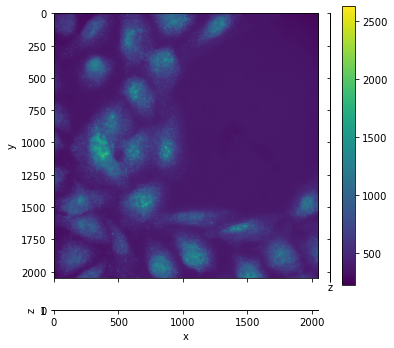

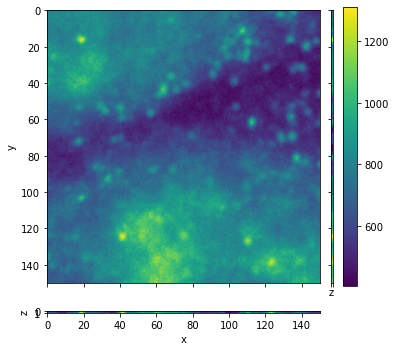

In [241]:
img = load_tiff_image(sorted(glob.glob(cfg.data_path.image_path))[0])[0][None]
_ = plot_3d_projections(img, size=5, proj_func=np.max)
sl = eval(cfg.evaluation.crop_sl,{'__builtins__': None},{'s_': np.s_})
_ = plot_3d_projections(img[sl[:]], size=5)

Create the dataloader which samples random subsets from the recorded volumes and generates simulated data that we use for training.  
For visualization purposes it is often better to not sample foci as they distort the colorscale.

In [243]:
n_foci = cfg.foci.n_foci_avg
cfg.foci.n_foci_avg = 0
img_3d, decode_dl = get_dataloader(cfg)
psf, noise, micro = load_psf_noise_micro(cfg)
cfg.foci.n_foci_avg = n_foci

Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
1 volumes


This function allows you to visually compare the recorded data and the simulations generated with the given config.  
For each sample we plot a slice from the input volume and from a simulated training volume as well as the estimated background.  
In the second row we compare maximum intensity projections.  

Adjust the microscope.scale and PSF.gauss_radii until you achieve a rough match in intensities and the PSF shape.  
You don't have to get this exactly right as these values get automatically fine tuned during training.
It is totally fine if average density of emitters in the simulations is higher than in the recordings.

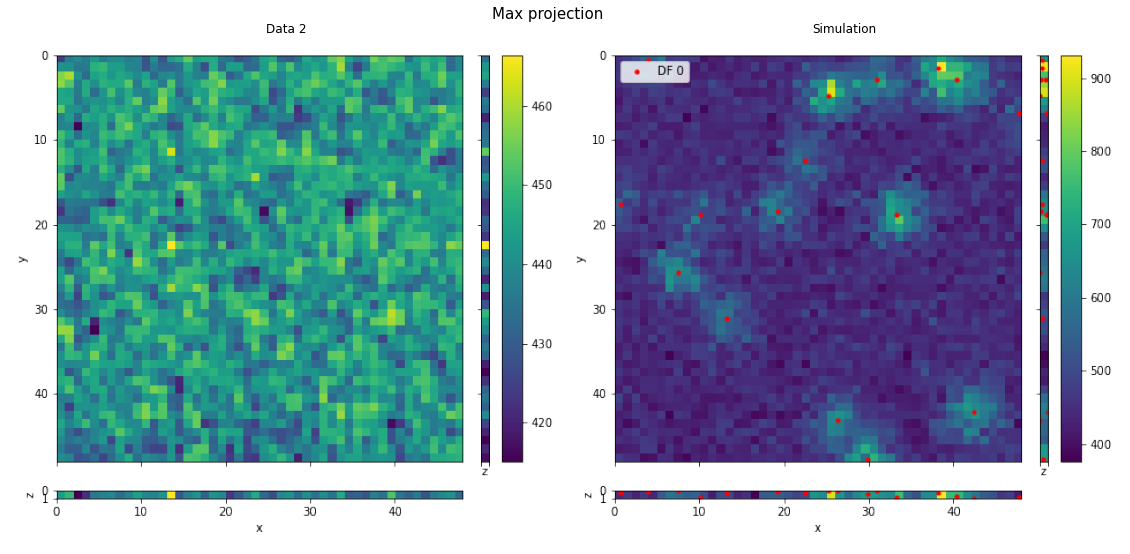

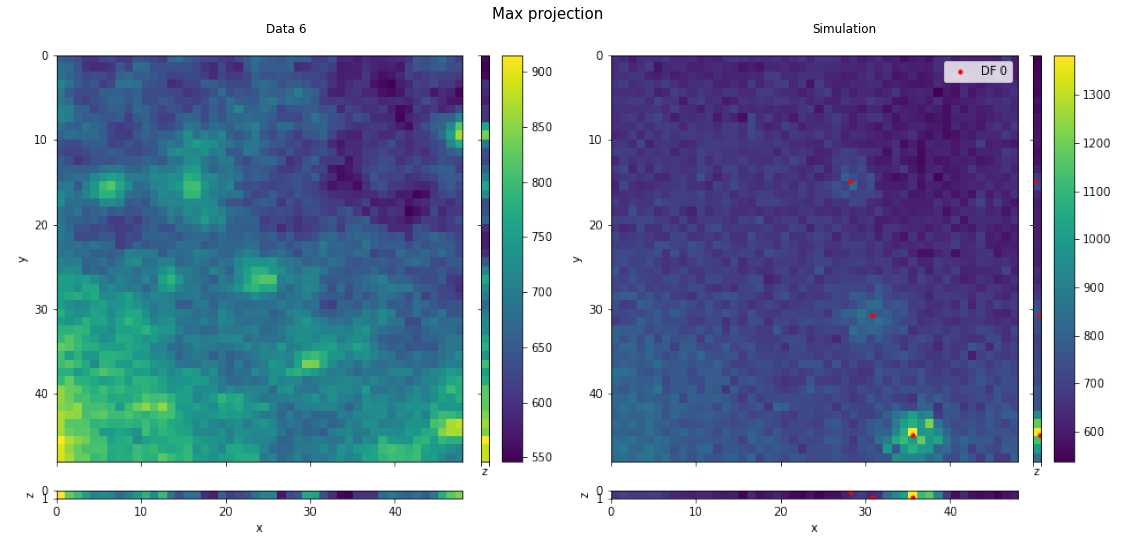

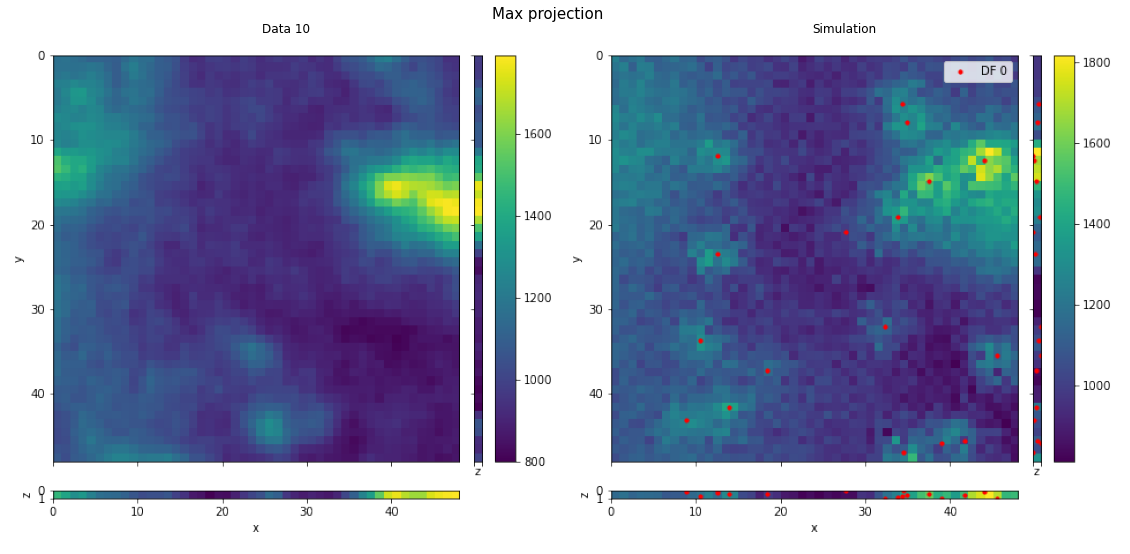

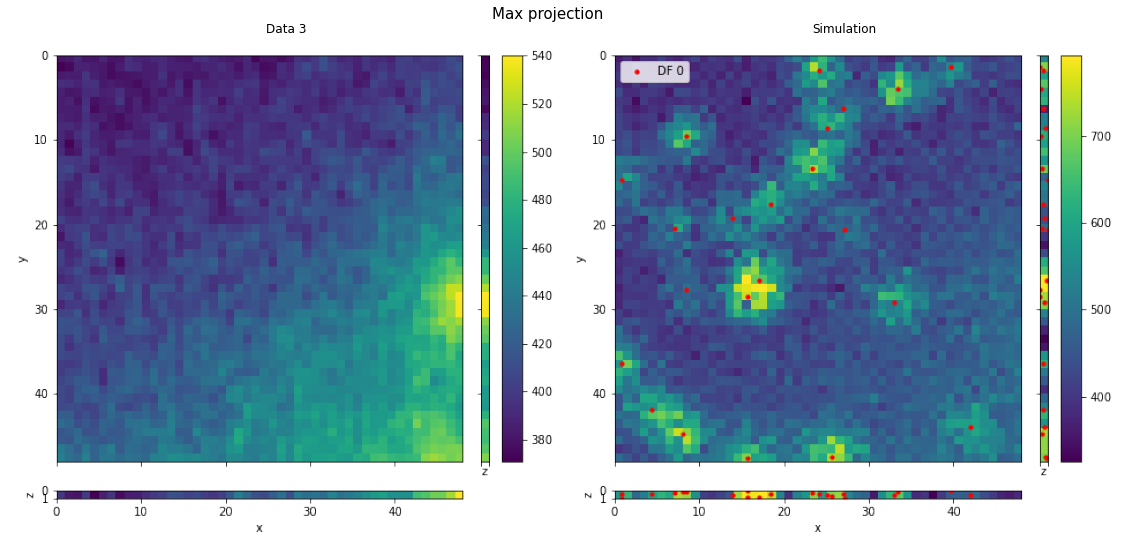

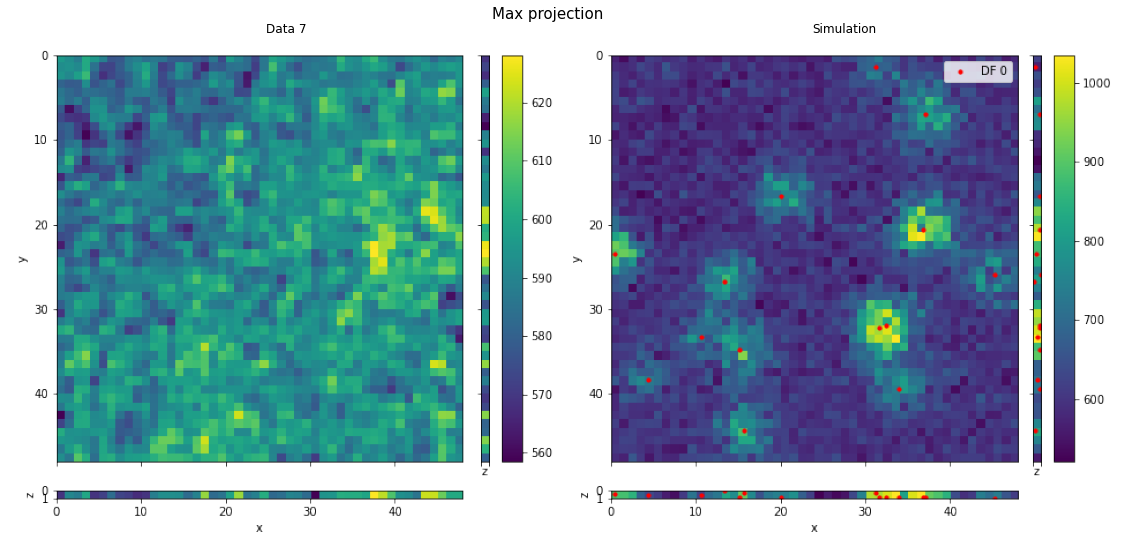

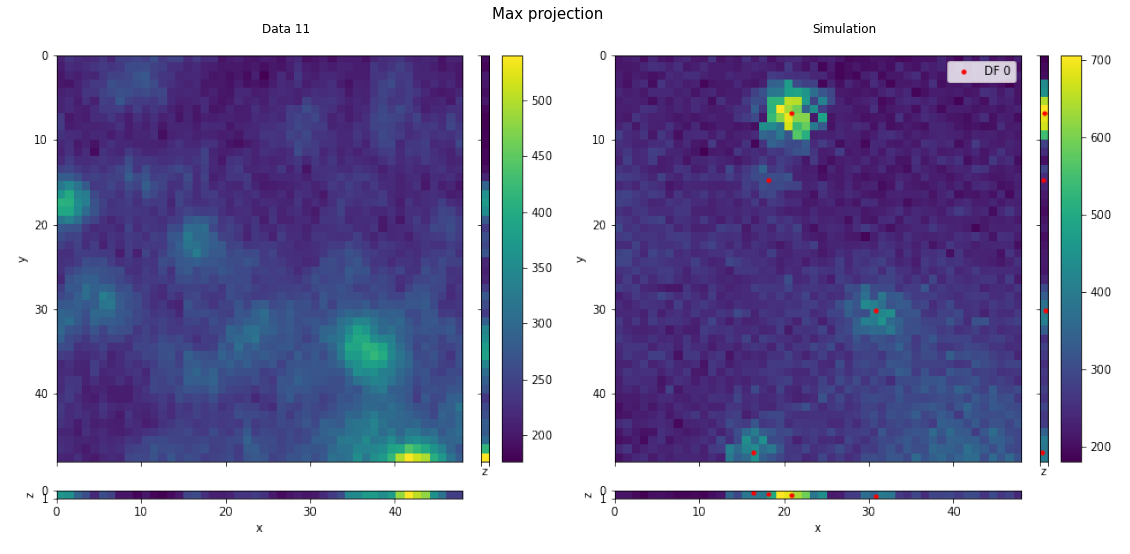

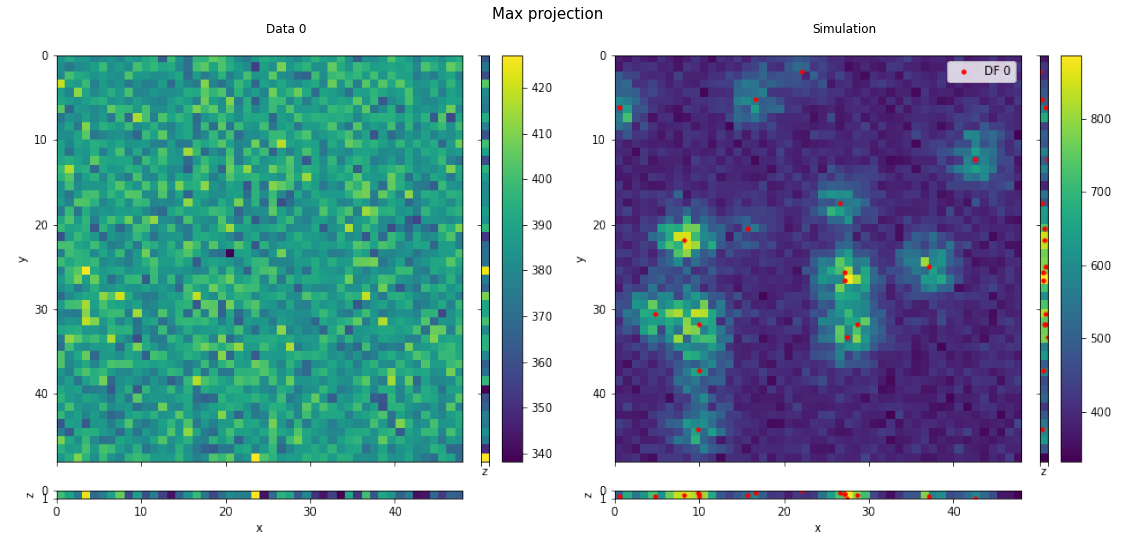

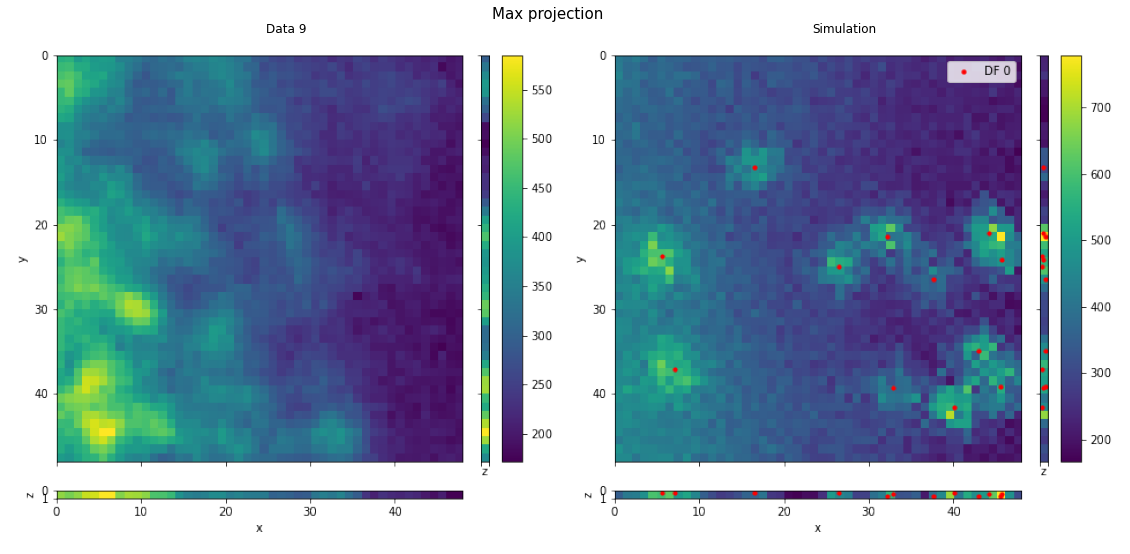

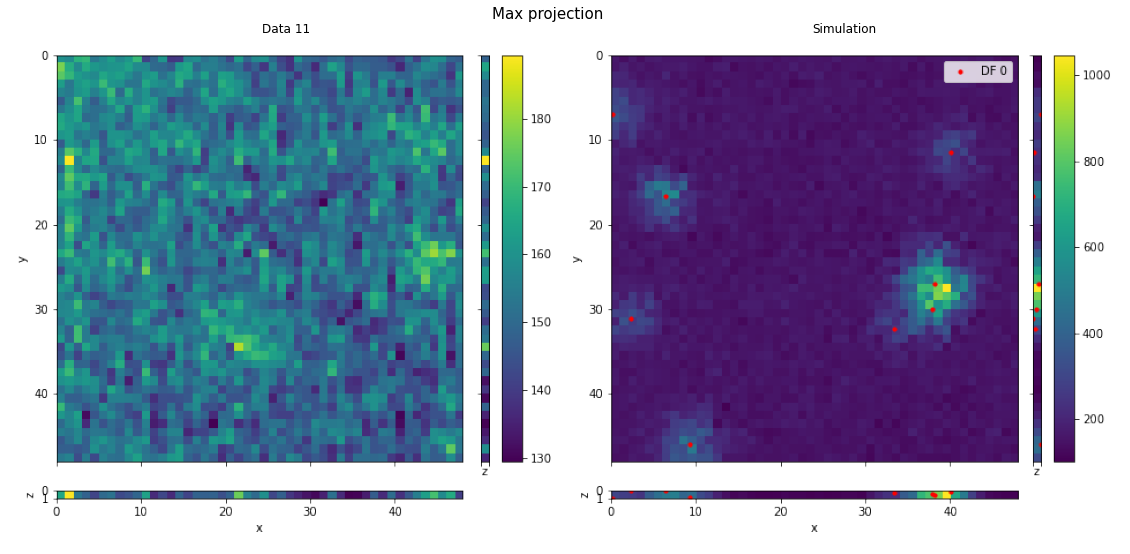

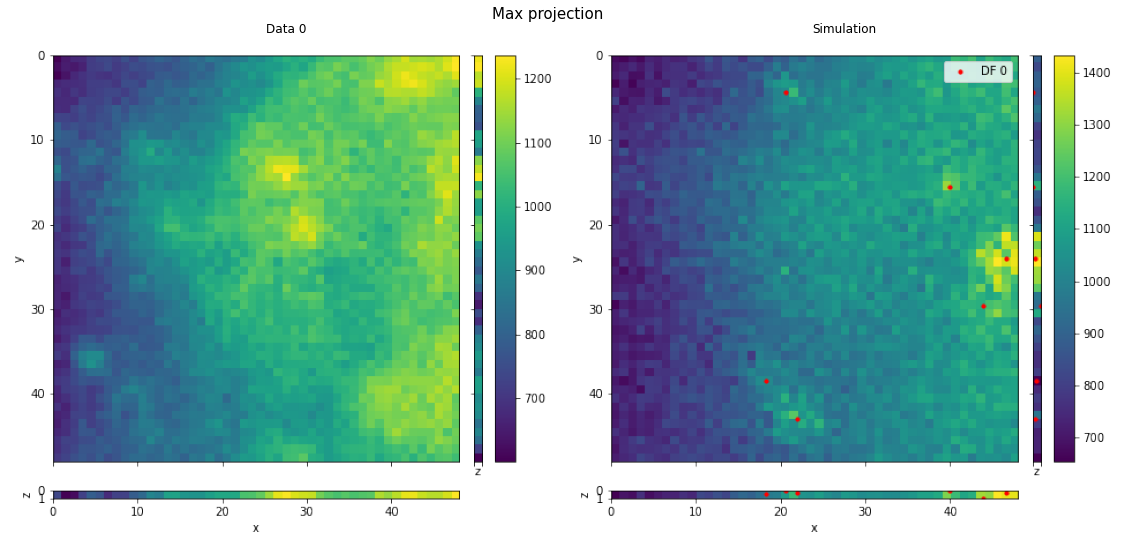

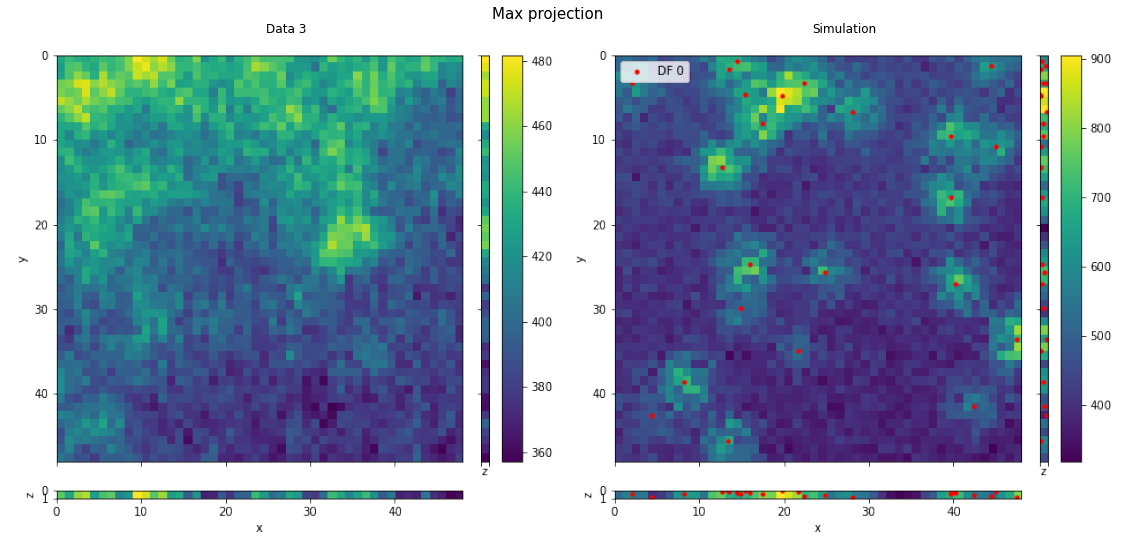

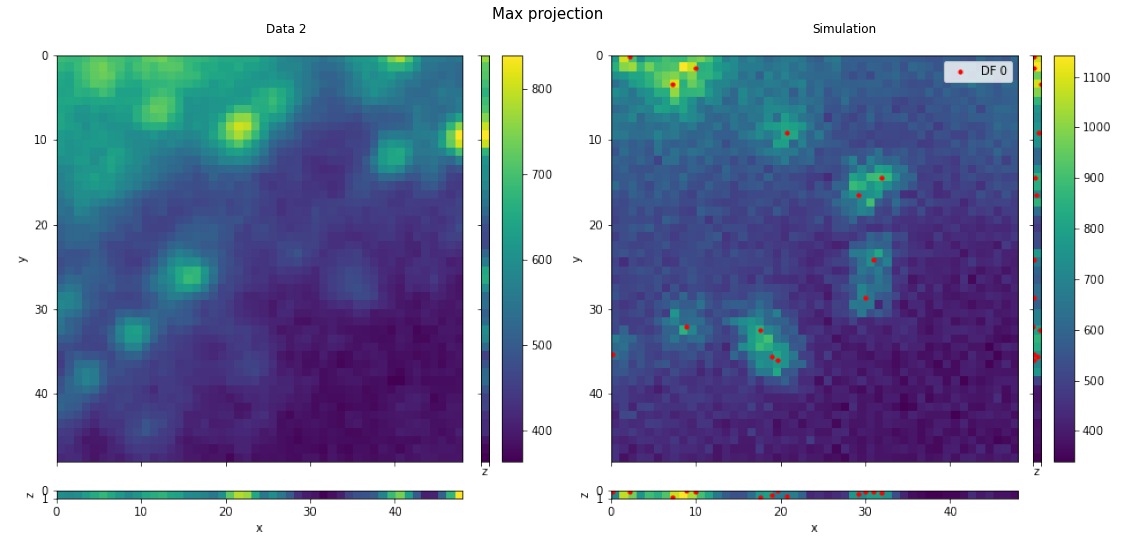

In [244]:
get_simulation_statistics(decode_dl, micro, **cfg.intensity_dist, int_threshold=0.1, samples=12, channels=cfg.exp_type.channels, n_bits=cfg.exp_type.n_bits, psf_noise=True)

# Evaluation

In [245]:
cfg.run_name = 'test'
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/sweep_ci_10/enabled:Truexenabled:Falsexpred_z:Falsexnorm:none/train.yaml')
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/sweep_ci_13/pred_z:Truexpsf_noise:0.4/train.yaml')
# cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/sweep_ci_13/psf_noise:0.4/train.yaml')
# cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/sweep_ci_11/psf_noise:0.5xpred_z:True/train.yaml')

In [246]:
# cfg.exp_type.pred_z=False
# cfg.PSF.psf_extent_zyx=[1,21,21]

In [247]:
# cfg.exp_type.pred_z = False

In [248]:
# Load the model, post processing, imgages, dataloader
model, post_proc, micro, img_3d, decode_dl = load_all(cfg)
# model, post_proc, _, _, _= load_all(cfg)
psf_init = get_gaussian_psf(cfg.PSF.psf_extent_zyx,cfg.PSF.gauss_radii, cfg.exp_type.pred_z)
psf_init = cpu(psf_init.psf_volume[0])
psf_vol = cpu(micro.psf.psf_volume[0])

Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
1 volumes


Plot mean projections of the PSF before and after optimizing it during training

(tensor(5.0000, device='cuda:0', grad_fn=<DivBackward0>), tensor(10.0000, device='cuda:0', grad_fn=<DivBackward0>), tensor(10.0000, device='cuda:0', grad_fn=<DivBackward0>))


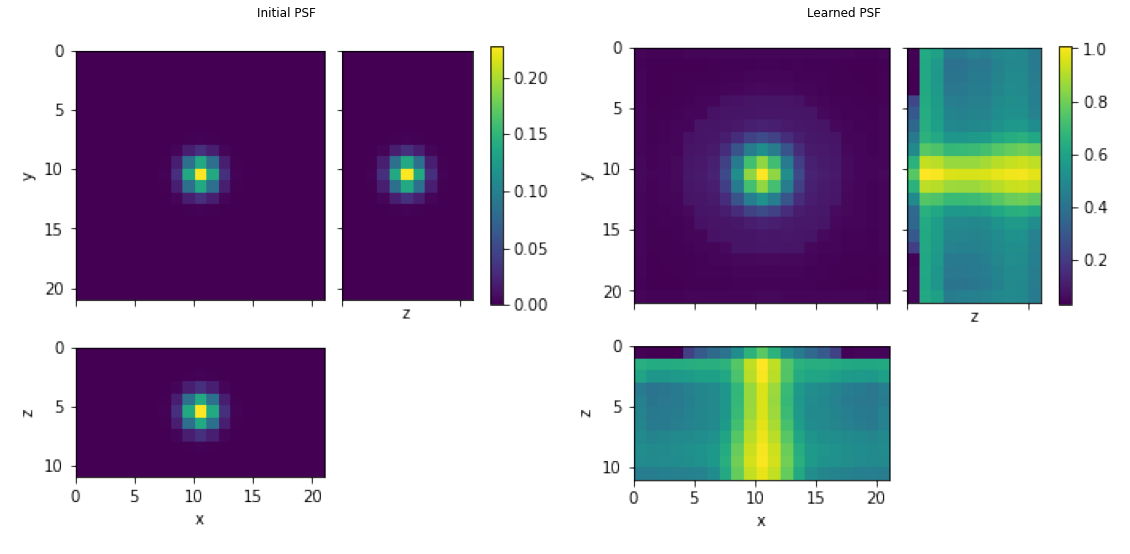

In [249]:
print(micro.psf.get_com())
fig1,_ =plot_3d_projections(psf_init, proj_func=np.mean, size=3, display=False)
fig2,_ =plot_3d_projections(psf_vol, proj_func=np.mean, size=3, display=False)
_ = combine_figures([fig1,fig2],['Initial PSF','Learned PSF'], nrows=1, ncols=2, figsize=(20,10))

0.9322049


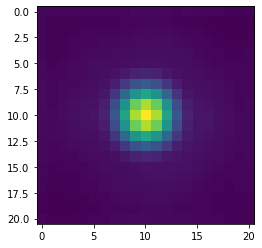

In [250]:
plt.imshow(psf_vol[8])
print(psf_vol[8].max())

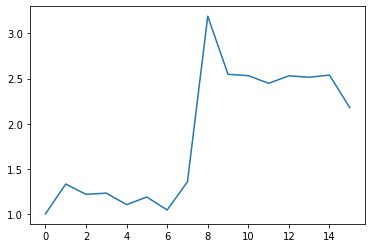

In [251]:
# plt.subplot(121)
plt.plot(cpu(micro.noise.theta_par*micro.noise.theta_scale))
# plt.plot(ref_theta)

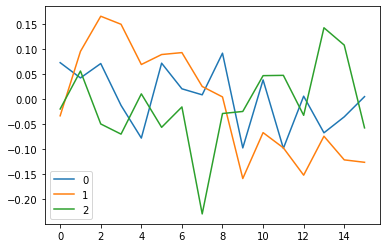

In [252]:
for i in range(3):
    plt.plot(cpu(micro.noise.channel_shifts[:,i]), label=i)
plt.legend()

Sample random sub volumes and overlay them with predictions,  also shows the residuals between the input volume and the reconstruction from applying the microscope and PSF model to those predictions. Sometimes it looks like the network if missing obvious molecules. Often times this is because they are at the very edge of the volume. In that case they will be localized once you process the whole volume.

In [253]:
# export
def get_prediction(model, post_proc, img, micro=None, cuda=True, return_rec=False, channel=0):
    
    with torch.no_grad():
        
        img = img[(None,)*(5-img.ndim)]
        model.eval().cuda() if cuda else model.eval().cpu()
        res_dict = model(img.cuda()) if cuda else model(img)
        res_dict = model.tensor_to_dict(res_dict)
        pred_df = post_proc.get_df(res_dict)

        
        if return_rec:
            locations, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape = post_proc.get_micro_inp(res_dict, channel=channel)
            ae_img_3d = micro(locations, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape, rec_ch=channel)   
            return pred_df, ae_img_3d + res_dict['background'][:,channel:channel+1], res_dict
            
        return pred_df

def eval_random_crop(decode_dl, model, post_proc, micro, proj_func=np.max, cuda=False, samples=1, int_threshold=1, plot='rec', crop_sz_xy=40, ret_preds=False):
    
    with torch.no_grad():
        
        decode_dl.dataset.dataset_tfms[0].crop_sz = (decode_dl.dataset.dataset_tfms[0].crop_sz[0], crop_sz_xy, crop_sz_xy)
        
        if ret_preds: samples = 1
        
        for _ in range(samples):
        
            x = torch.zeros(1)
            while x.max() < int_threshold:
                x, local_rate, background = next(iter(decode_dl))
                
            rand_ch = np.random.randint(0, x.shape[1])
            
            pred_df, rec, res_dict = get_prediction(model, post_proc, x[:1], micro=micro, cuda=True, return_rec=True, channel=rand_ch)
            pred_df = nm_to_px(pred_df, post_proc.px_size_zyx)
            
            pred_df = pred_df[pred_df[f'int_{rand_ch}'] > 0.03]

            x_plot = x[0,rand_ch].cpu().numpy()
            rec = rec[0,0].cpu().numpy()

            fig1, axes = plot_3d_projections(x_plot, proj_func=proj_func, display=False)
            scat_3d_projections(axes, [pred_df])
            
            if 'res' in plot:

                diff = abs(x_plot-rec)
                fig2, axes = plot_3d_projections(diff, proj_func=proj_func, display=False)
                combine_figures([fig1,fig2], ['Predictions', 'Residual'], figsize=(20,10))
  
            if 'rec' in plot:

                fig2, axes = plot_3d_projections(rec, proj_func=proj_func, display=False)
                combine_figures([fig1,fig2], ['Predictions', 'Reconstruction'], figsize=(20,10))
                
            if 'bg' in plot:

                fig2, axes = plot_3d_projections(res_dict['background'], proj_func=proj_func, display=False)
                combine_figures([fig1,fig2], ['Predictions', 'BG pred.'], figsize=(20,10))
                
        if ret_preds:
            
            return x, pred_df, rec, res_dict

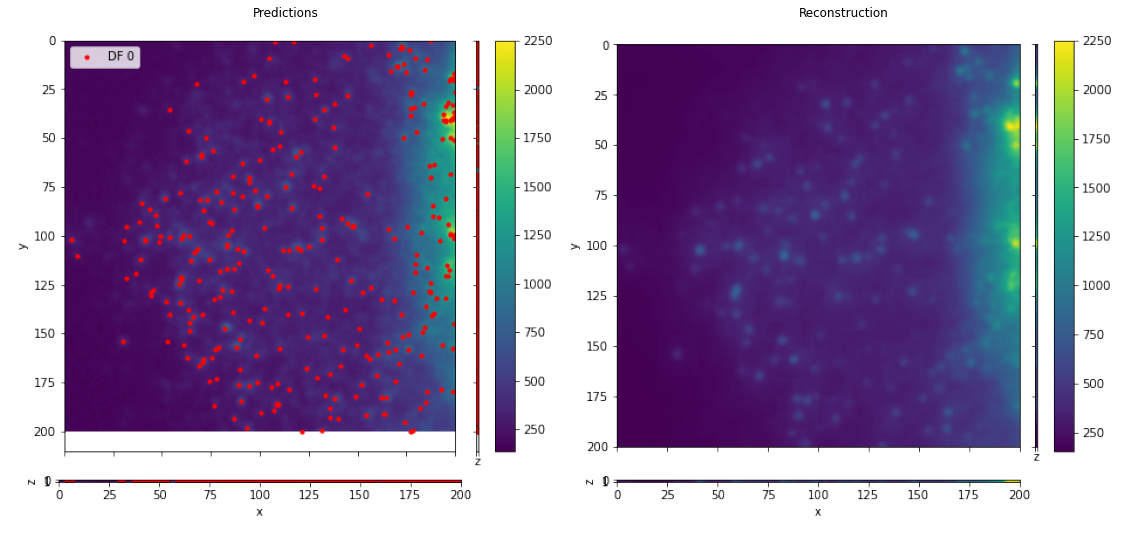

In [254]:
x, pred_df, rec, res_dict = eval_random_crop(decode_dl, model, post_proc, micro, samples=10, plot='rec', crop_sz_xy=200, ret_preds=True)

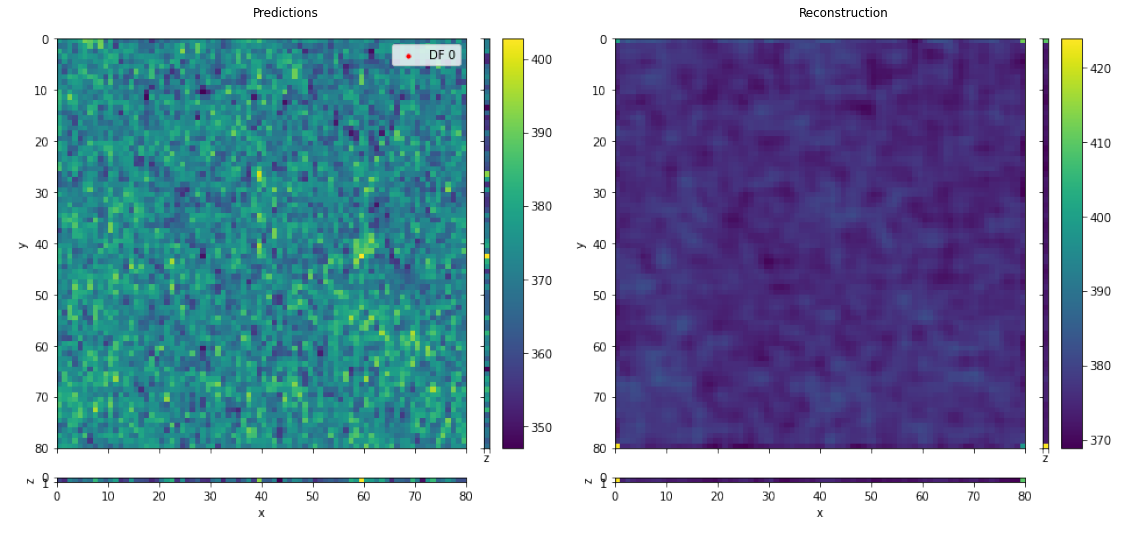

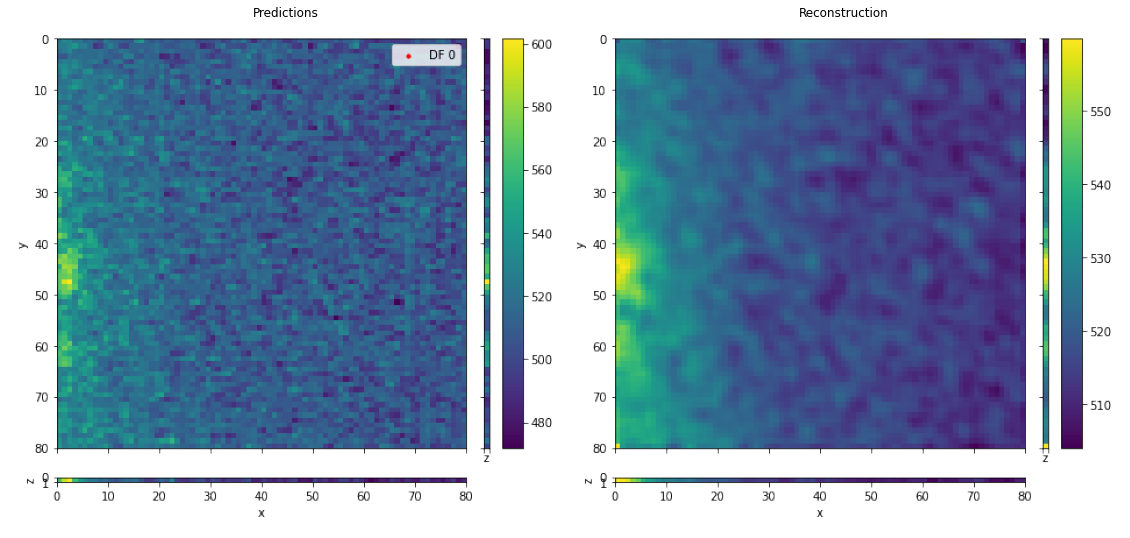

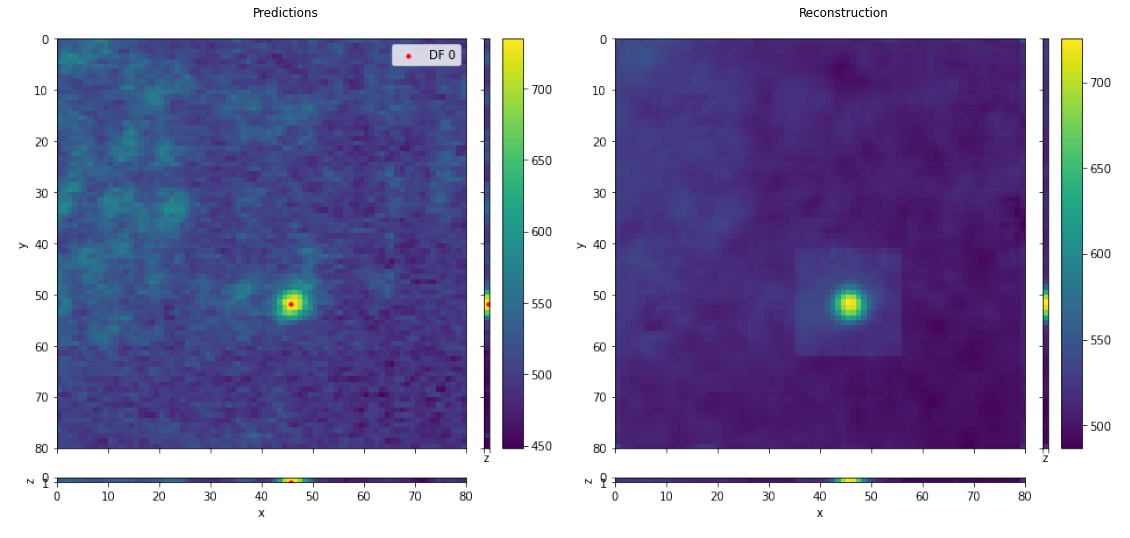

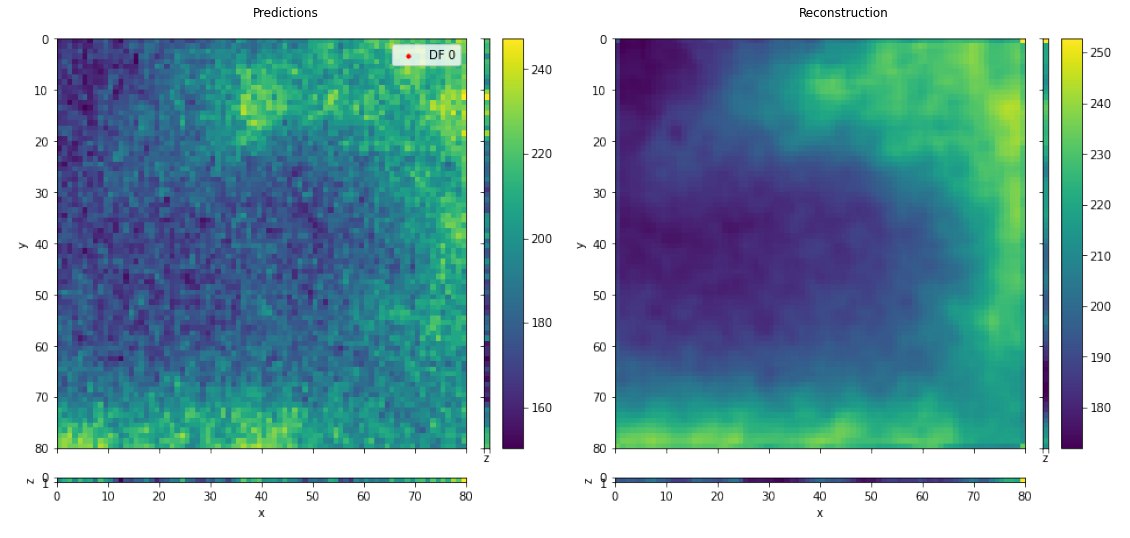

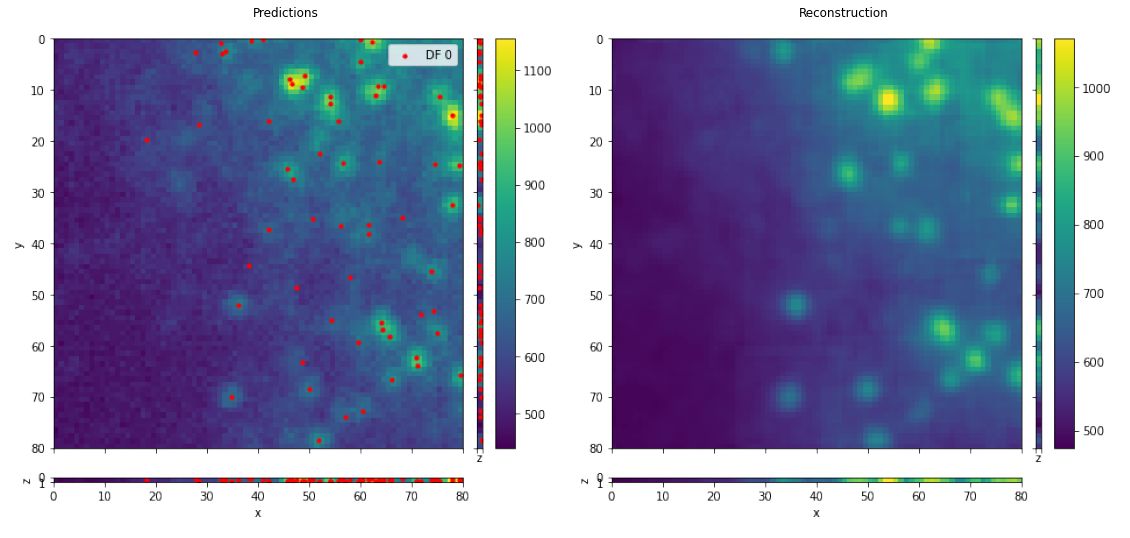

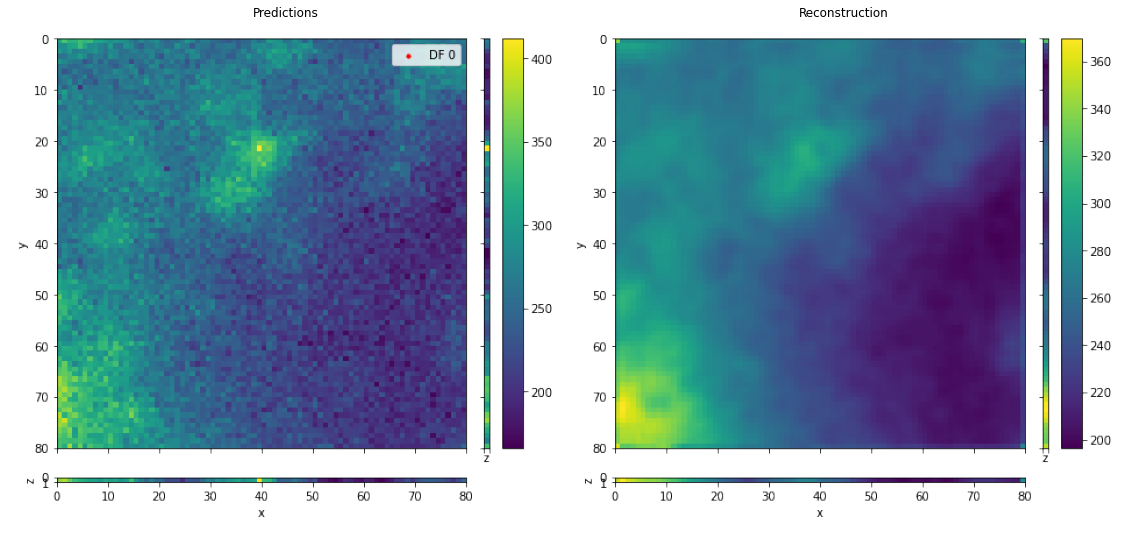

In [255]:
eval_random_crop(decode_dl, model, post_proc, micro, samples=6, plot='rec', crop_sz_xy=80)

In [256]:
cfg.foci.n_foci_avg = 0
cfg.training.bs = 10
img_3d, decode_dl = get_dataloader(cfg)

Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
1 volumes


In [257]:
from decode_fish.engine.point_process import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.evaluation import *
from decode_fish.engine.gmm_loss import *

micro.psf_noise = 0.4

with torch.no_grad():
    x, local_rate, background = next(iter(decode_dl))
    sim_vars = PointProcessUniform(local_rate*1.,model.int_dist.int_conc, model.int_dist.int_rate, model.int_dist.int_loc, channels=16, n_bits=4, sim_z=cfg.exp_type.pred_z).sample()
    xsim = micro(*sim_vars, add_noise=False)
    x = micro.noise(xsim, background).sample()

    gt_vars = sim_vars[:-1]
    gt_df = sample_to_df(*gt_vars, px_size_zyx=[1.,1.,1.])

    print(len(gt_df))

    model.eval().cuda()
    res_dict = model(x.cuda())
    res_dict = model.tensor_to_dict(res_dict)
#     res_dict['xyzi_mu'][:,3:] = res_dict['xyzi_mu'][:,3:]# * 0  + torch.tensor(gt_ints)[:,:,None,None,None].cuda()
#     res_dict['xyzi_sigma'][:,3:] = res_dict['xyzi_sigma'][:,3:] 
    count_prob, spatial_prob = PointProcessGaussian(**res_dict).log_prob(*sim_vars[:5], 
                                                  n_bits=cfg.exp_type.n_bits, channels=cfg.exp_type.channels, min_int_sig=cfg.training.net.min_int_sig)
    
    pred_df = post_proc.get_df(res_dict)

468


In [258]:
x_nobg = xsim + background*0 + background.mean()
i = 0

# fig, ax = plot_3d_projections(x[i,0])
gt_sub = gt_df
pred_sub = nm_to_px(pred_df)
# scat_3d_projections(ax, [gt_sub, pred_sub])

perf, matches, _ = matching(px_to_nm(gt_sub), px_to_nm(pred_sub), tolerance=500, print_res=True)

Recall: 0.846
Precision: 0.992
Jaccard: 84.076
RMSE_vol: 46.750
Eff_3d: 71.717
FN: 72.0 FP: 3.0
Num. matches: 396.000
Shift: 1.90,-1.40,-4.14


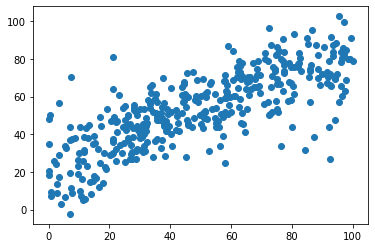

In [259]:
plt.scatter(matches['z_tar'], matches['z_pred'])

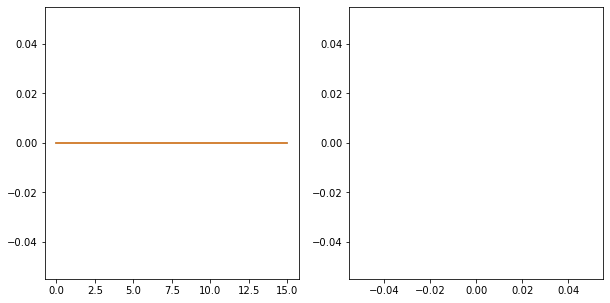

In [1744]:
ints = [f'int_pred_{i}' for i in range(16)]
int_pred = matches[ints].values
ints = [f'int_tar_{i}' for i in range(16)]
int_tar = matches[ints].values
ints = [f'int_sig_pred_{i}' for i in range(16)]
int_sig = matches[ints].values

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(int_pred.sum(0))
plt.plot(int_tar.sum(0))
plt.subplot(122)
plt.plot(np.where(int_pred>0.04,1,0).sum(1))
plt.plot(np.where(int_tar>0.04,1,0).sum(1))

In [1685]:
corrs = [np.corrcoef(matches[f'int_pred_{i}'],matches[f'int_tar_{i}'])[0,1] for i in range(16)]
# np.corrcoef(int_pred.sum(-1),int_tar.sum(-1))[0,1]

0.6224325124996748

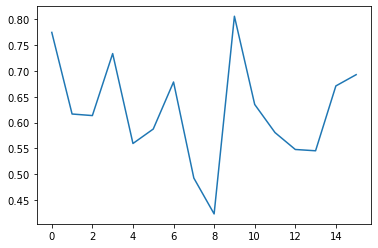

In [1686]:
plt.plot(corrs)
np.mean(corrs)

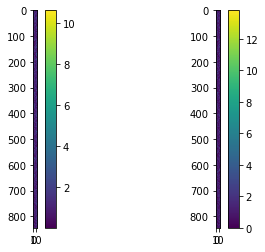

In [1619]:
plt.subplot(121)
plt.imshow(int_pred)
plt.colorbar()
plt.subplot(122)
plt.imshow(int_tar)
plt.colorbar()

In [79]:
from decode_fish.engine.point_process import PointProcessUniform
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.evaluation import *

def sim_data(decode_dl, batches, micro, model, channels=1, n_bits=1, sim_z=True):
    
    gt_dfs = []
    xsim_col = []
    
    for _ in range(batches):
        with torch.no_grad():
            x, local_rate, background = next(iter(decode_dl))
            sim_vars = PointProcessUniform(local_rate*1. ,model.int_dist.int_conc, model.int_dist.int_rate, model.int_dist.int_loc, channels=channels, n_bits=n_bits, sim_z=sim_z).sample()
            xsim = micro(*sim_vars)
            x = micro.noise(xsim, background*0 + background.mean()).sample()

            xsim_col.append(x)
            gt_vars = sim_vars[:-1]
            gt_df = sample_to_df(*gt_vars, px_size_zyx=[1.,1.,1.])
            gt_dfs.append(gt_df)
        
    return torch.cat(xsim_col), cat_emitter_dfs(gt_dfs, decode_dl.batch_size)

def get_sim_perf(x, gt_df, model, post_proc, micro, cuda=True, print_res=True):

    pred_dfs = []
    x_recs = []
    
    for i in range(len(x)):
        with torch.no_grad():
            pred_df, rec, res_dict = get_prediction(model, post_proc, x[i:i+1], micro=micro, cuda=True, return_rec=True)
            pred_dfs.append(pred_df)
            x_recs.append(rec)
        
    pred_df = cat_emitter_dfs(pred_dfs)
    xrec = torch.cat(x_recs)
    perf, matches, _ = matching(gt_df, pred_df, tolerance=500, print_res=print_res)
    perf['mae'] = abs(xrec-rec).mean().item()
    perf['rmse'] = torch.sqrt(((xrec-rec)**2).mean()).item()
    
    return perf, pred_df, matches, xrec


In [81]:
# from decode_fish.funcs.routines import *
xsim, gt = sim_data(decode_dl, 5, micro,model, channels=16, n_bits=4, sim_z=cfg.exp_type.pred_z)
perf, pred_df, matches, rec = get_sim_perf(xsim, px_to_nm(gt, cfg.evaluation.px_size_zyx), model, post_proc, micro, print_res=True)

Recall: 0.883
Precision: 0.989
Jaccard: 87.444
RMSE_vol: 54.918
Eff_3d: 69.807
FN: 411.0 FP: 36.0
Num. matches: 3113.000
Shift: -2.03,-2.44,0.00


In [1014]:
print(*model.int_dist.parameters())

Parameter containing:
tensor(4., device='cuda:0', requires_grad=True) Parameter containing:
tensor(1., device='cuda:0', requires_grad=True) Parameter containing:
tensor(0.5000, device='cuda:0', requires_grad=True)


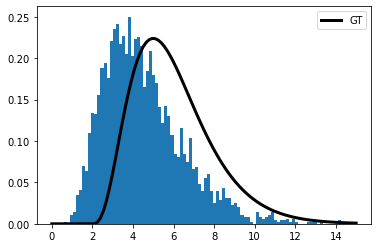

In [1015]:
import scipy.stats as stats  

x = np.linspace(0,15,101)

y = stats.gamma.pdf(x, 4., 2., 1/1.)
plt.plot(x, y, label='GT', linewidth=3, color='black')
plt.hist(gt['int'], bins=np.linspace(0,15,101), density=True)
    
plt.legend()

In [1016]:
# i = 6
# fig, ax = plot_3d_projections(xsim[i,0])
# gt_sub = gt[(gt['ch_idx']==0) & (gt['frame_idx'] == i)]
# pred_sub = nm_to_px(pred_df)[pred_df['frame_idx'] == i]
# scat_3d_projections(ax, [gt_sub, pred_sub])

# perf, matches, _ = matching(px_to_nm(gt_sub), px_to_nm(pred_sub), tolerance=500, print_res=True)

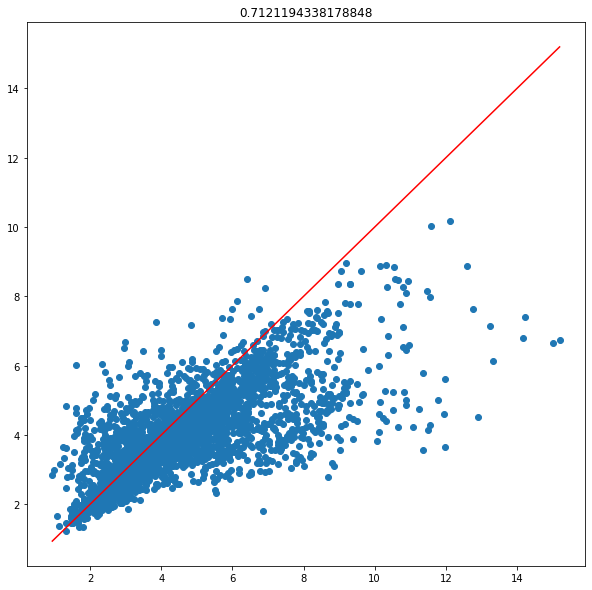

In [1017]:
plt.figure(figsize=(10,10))
corr_scatter(matches['int_tar'], matches['int_pred'])

If you are happy with the results you can run the network on whole volumes to get predictions. Be aware that a model will only produce good results on different recordings if the conditions with regards to PSF and intensity are similar as those used during training.

In [286]:
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/sweep_ci_14/enabled:Truexpsf_noise:0.6/train.yaml')

In [287]:
model, post_proc, micro, img_3d, decode_dl = load_all(cfg)

Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
1 volumes


In [288]:
from monai.inferers import sliding_window_inference
def predict(model, post_proc, image_paths, window_size=[None,256,256], device='cuda'):
    pred_df = DF()
    with torch.no_grad():
        for p in image_paths:
            print(p.split('/')[-1])
            img = load_tiff_image(p)[None]

            n_chans = img.shape[1]
            print(img.shape)
            z, y, x = img.shape[-3:]
                
            inp = img
#                 inp[:,1:] = torch.flip(inp[:,1:], dims=[4])
            output = sliding_window_inference(inp, window_size, 1, model.to(device), overlap=0.2, sw_device=device, device='cpu', mode='gaussian')
            # output = model.cpu()(img[None,None])
            output = model.tensor_to_dict(output)
            p_si = sliding_window_inference(output['logits'], window_size, 1, post_proc, overlap=0.2, sw_device=device, device='cpu', mode='gaussian')
            i_df = post_proc.get_df(output, p_si)
            print('N. emitters: ', len(i_df))
            i_df.loc[:,'frame_idx'] = 0
            pred_df = append_emitter_df(pred_df, i_df)
            free_mem()
        return pred_df

In [290]:
model, post_proc, micro, img_3d, decode_dl = load_all(cfg)

image_paths = sorted(glob.glob(cfg.data_path.image_path))
inf_df = predict(model, post_proc, image_paths, window_size=[None, 256, 256], device='cuda')
inf_df.to_csv(f'../data/results/MERFISH/exp_ci14_t06.csv', index=False)

Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
1 volumes
img_stack.tiff
torch.Size([1, 16, 1, 2048, 2048])
N. emitters:  35941


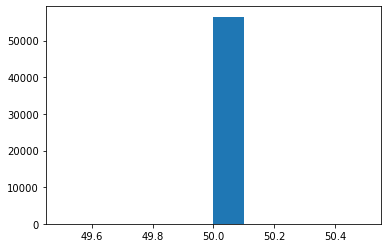

In [266]:
_ = plt.hist(inf_df['z'])

In [1055]:
# sl = np.s_[:,:,500:1250,1100:1700]
# sl = np.s_[:,:,:,:]
# img = load_tiff_image(image_paths[0])
# for i in range(16):

#     preds_px = nm_to_px(inf_df[inf_df['frame_idx']==(i)])
#     plt.figure(figsize=(25,25))
#     im = plt.imshow(img[i,0][sl[2:]])
#     add_colorbar(im)
#     sub_preds = crop_df(preds_px, sl)
#     plt.scatter(sub_preds['x'],sub_preds['y'], color='red', s=3.5)
#     plt.show()

In [1056]:
inf_df

,loc_idx,frame_idx,x,y,z,prob,int,int_sig,x_sig,y_sig,z_sig,comb_sig
0,0,0,10030.624023,-40.069401,50.0,0.616795,1.636275,0.268369,49.955494,15.365103,100.0,1.128346
1,1,0,10515.877930,-38.880039,50.0,0.710649,1.594283,0.278484,47.516953,16.620550,100.0,1.119558
2,2,0,15623.184570,-38.628578,50.0,0.843763,1.744576,0.248061,39.356392,17.536453,100.0,1.088873
3,3,0,17218.617188,-36.732559,50.0,0.837575,1.655923,0.274061,36.666962,12.912500,100.0,1.072903
4,4,0,39329.972656,-37.195492,50.0,1.000000,1.946480,0.300813,38.410427,13.889533,100.0,1.080198
...,...,...,...,...,...,...,...,...,...,...,...,...
288331,288331,15,190996.437500,204729.265625,50.0,0.552512,2.501016,0.580236,39.430367,43.459583,100.0,1.159461
288332,288332,15,191300.312500,204734.171875,50.0,0.523607,1.842537,0.453270,46.852898,40.056522,100.0,1.174722
288333,288333,15,196029.734375,204771.328125,50.0,0.808029,4.931407,0.608262,18.751755,17.448524,100.0,1.032283
288334,288334,15,199073.453125,204762.296875,50.0,0.915105,2.169853,0.375099,26.965878,18.041250,100.0,1.051316
